# Learning Goals

The goal of this assignment is to develop an understanding of how the brain performs computations at the neuronal level. To do so, you will develop several models of a spiking neuron. By the end of this assignment, you should a) be comfortable with developing models of spiking neurons at different levels of abstraction, from the biologically plausible H-H model to the phenomenological LIF model; b) understand how neurons use their firing rate to represent continuous-valued information; and c) understand the trade-offs involved in spike-based information representation. 

*More theoretical information can be found here: https://neuronaldynamics.epfl.ch/online/Ch2.html*

Let's first import all the libraries required for this assignment

In [45]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import random

# Question 1: The Hodgkin Huxley Neuron

Before proceeding, please thoroughly review the [WIKI link](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model)  and the research paper by Hodgkin and Huxley titled [Hodgkin A L, Huxley A F. A quantitative description of membrane current and its application to conduction and excitation in nerve, 1952](./HH.pdf). All necessary information for the Question 1 can be found in these sources. Additionally, please note the following:

1. To ensure depolarization is interpreted as a positive event, indicating the influx of positive ions into a neuron resulting in increased positivity at points of equilibrium voltage or constant, the sign on relevant variables should be reversed.
2. Utilize the formulas provided in the Wikipedia article as a framework for the code. (The formulas have been adjusted the notation in accordance with the reversal described in point 1).
3. Attempt to comprehend the underlying logic derived from the formulas rather than solely seeking the solution. By doing so, you'll seize the chance to grasp the intricacies of Nobel Prize-worthy research.


## 1a.

We will start by implementing the different computational models of a spiking neuron, with the aim of understanding the differences between the different models. We will start with one of the earliest, yet one of the most biologically faithful models of a neuron - The Hodgkin-Huxley (HH) model. Below is the class definition of an HH neuron. Your first task is to fill the different components required to simulate an HH neuron.


In [46]:
class HodgkinHuxley():
    """Implementation of Hodgkin Huxley Model"""
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt, reset, I_inj, pronase=False):
        """
        :param C_m: membrane capacitance in uF/cm^2
        :param g_Na: Sodium conductance in mS/cm^2
        :param g_K: Potassium conductance in ms/cm^2
        :param g_L: Leak maximum conductance
        :param E_Na: Sodium Nernst reversal potential in mV
        :param E_K: Potassium Nernst reversal potential in mV
        :param E_L: Leak Nernst reversal potential in mV
        :param T: Simulation timesteps
        :param dt: Integration time 
        :param reset: Reset potential
        :param I_ink: injected current
        
        This function is complete. You do not need to do anything here.
        """
        self.C_m = C_m 
        self.g_Na = g_Na 
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt) #*time to integrate over
        self.n = np.zeros_like(self.t) #* history array to record all the "n"
        self.m = np.zeros_like(self.t) #* history array to record all the "m"
        self.h = np.zeros_like(self.t) #* history array to record all the "h"
        self.V = np.zeros_like(self.t) #* history array to record all the "V"
        self.reset = reset
        self.I_inj = I_inj
        self.pronase = pronase
    
    def alpha_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_m
        """
        return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)
    
    def beta_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_m
        """
        return 4 * np.exp(-V / 18)
    
    def alpha_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_h
        """
        return 0.07 * np.exp(-V / 20)
    
    def beta_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_h
        """
        return 1 / (np.exp((30 - V) / 10) + 1)
    
    def alpha_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_n
        """
        return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)
    
    def beta_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_n
        """
        return 0.125 * np.exp(-V / 80)
    
    def I_Na(self, V, m, h):
        """
        Membrane Sodium current
        :param V: membrane voltage
        :param m: gating variable m
        :param h: gating variable h
        :return: sodium current I_Na
        """
        return self.g_Na * m**3 * h * (V - self.E_Na)
    
    def I_K(self, V, n):
        """
        Membrane Potassium current
        :param V: membrane voltage
        :param h: gating variable h
        :return: Potassium current I_K
        
        Fill in the equation for I_K
        """
        return self.g_K * n**4 * (V - self.E_K)
    
    def I_L(self, V):
        """
        Membrane Leak current
        :param V: membrane voltage
        :return: Leak current I_L
        
        Fill in the equation for I_L
        """
        return self.g_L * (V - self.E_L)

    
    def update(self,t):
        """
        Function to integrate membrane potential and activation variables by timestep t
        :param t: timestep

        """
        if t > 0:
            V = self.V[t-1]

            #* when timestep is not 0, update the "n", "m", "h", "V"
            temp_I_Na = self.I_Na(V, self.m[t-1], self.h[t-1])
            temp_I_K = self.I_K(V, self.n[t-1])
            temp_I_L = self.I_L(V)
            I_ion = temp_I_Na + temp_I_K + temp_I_L
            self.V[t] = V + self.dt * ((self.I_inj - I_ion) / self.C_m)
            self.n[t] = self.n[t-1] + self.dt * (self.alpha_n(V) * (1 - self.n[t-1]) - self.beta_n(V) * self.n[t-1])
            self.m[t] = self.m[t-1] + self.dt * (self.alpha_m(V) * (1 - self.m[t-1]) - self.beta_m(V) * self.m[t-1])
            if not self.pronase:
                self.h[t] = self.h[t-1] + self.dt * (self.alpha_h(V) * (1 - self.h[t-1]) - self.beta_h(V) * self.h[t-1])


        else: 
            #* when t==0, INITIALIZE the necessary variables for the coming calculation
            V = self.reset
            self.n[t] = self.alpha_n(V) / (self.alpha_n(V) + self.beta_n(V))
            self.m[t] = self.alpha_m(V) / (self.alpha_m(V) + self.beta_m(V))
            self.h[t] = self.alpha_h(V) / (self.alpha_h(V) + self.beta_h(V))
            self.V[t] = V 

    
    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here. 
        """
        _ = [self.update(t) for t in range(len(self.t))]
        self.V += self.reset

## 1b. 
Initialize an HH neuron using a proper set of parameters; then run the simulation. You should be able to get a plot depicting how the Voltage and Current of the neuron change with time. The result should looks like this ->


![1b](./1b.png)

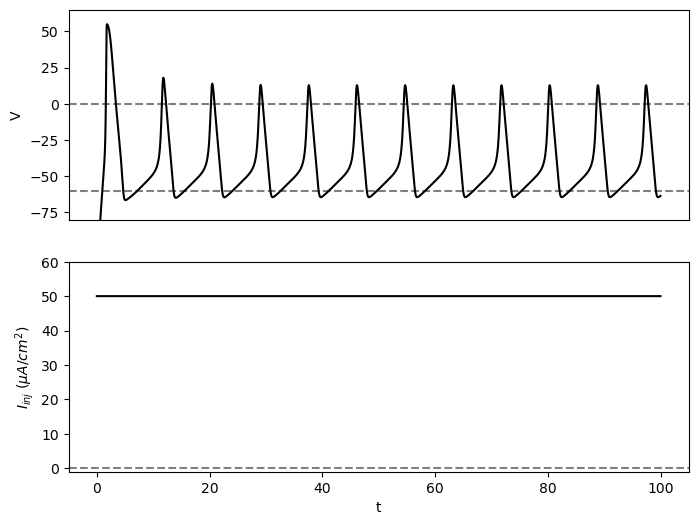

In [47]:

"""
(1. Initialize an hh neuron using the class definition above)
You can find all the corresponding values in the paper
Do not forget to reverse the signs of the one related to voltage!
"""
hh = HodgkinHuxley(
    C_m=1.0,  # Membrane capacitance
    g_Na=120.0,  # Sodium conductance
    g_K=36.0,  # Potassium conductance
    g_L=0.3,  # Leak conductance
    E_Na=115.0,  # Sodium reversal potential (reversed sign)
    E_K=-12.0,  # Potassium reversal potential
    E_L=10.6,  # Leak reversal potential
    T=100,
    dt=0.01,
    reset=-60,
    I_inj=50,
)
#2. Run the hh neuron simulation
hh.run()

#3 plot it 
"""
(DO NOT edit the plot code)
"""
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
# plt.title("Hodgkin-Huxley Neuron")
ax1.axhline(0, color="k", linestyle="--", alpha=0.5)
ax1.axhline(hh.reset, color="k", linestyle="--", alpha=0.5)
ax1.plot(hh.t, hh.V, "k")
ax1.set_ylabel("V")
ax1.set_ylim(-80, np.max(hh.V) + 10)
ax1.set_xticks([])
ax1.set_xticklabels([])
I_inj = [hh.I_inj for t in hh.t]
ax2.plot(hh.t, I_inj, "k")
ax2.set_xlabel("t")
ax2.axhline(0, color="k", linestyle="--", alpha=0.5)
ax2.set_ylabel("$I_{inj}$ ($\\mu{A}/cm^2$)")
ax2.set_ylim(-1, np.max(I_inj) + 10)

plt.show()

## 1c. 
The beauty of a neurophysiologically accurate model of a neuron is that it allows the simulation of several phenomena that can take place in the brain. Assume that you administer a drug named Tetrodotoxin (TTX), which is a potent neurotoxin that inhibits the voltage-gated sodium channels, and therefore decreases the sodium current. Simulate the effects that administering TTX would have on the neural firing.  Do the same for another drug, pronase,
which eliminates sodium inactivation. 

In [48]:
#1. Initialize an hh neuron to simulate TTX
hh = HodgkinHuxley(
    C_m=1.0,  # Membrane capacitance
    g_Na=0,  # Sodium conductance (set to 0)
    g_K=36.0,  # Potassium conductance
    g_L=0.3,  # Leak conductance
    E_Na=115.0,  # Sodium reversal potential (reversed sign)
    E_K=-12.0,  # Potassium reversal potential
    E_L=10.6,  # Leak reversal potential
    T=10,
    dt=0.001,
    reset=-60,
    I_inj=50,
)

#2. Run the hh neuron simulation
# notice that the depolarization is not happening to the same extent
hh.run()

#3. Initialize an hh neuron to simulate pronase
hh = HodgkinHuxley(
    C_m=1.0,  # Membrane capacitance
    g_Na=120,  # Sodium conductance
    g_K=36.0,  # Potassium conductance
    g_L=0.3,  # Leak conductance
    E_Na=115.0,  # Sodium reversal potential (reversed sign)
    E_K=-12.0,  # Potassium reversal potential
    E_L=10.6,  # Leak reversal potential
    T=10,
    dt=0.001,
    reset=-60,
    I_inj=50,
    pronase=True
)

#4. Run the hh neuron simulation
hh.run()

## 1d. (extra 10 points)

Try to modify the code in the “HodgkinHuxley” class to dynamically show how the HH model will behave as the current magnitude increases. The expected gif results should look like ->

 ![here](./1d.gif)

In [49]:
%matplotlib inline

In [50]:
# Simulation parameters
current_range = np.linspace(-12, 120, 20)
simulations = []

# Run simulation for each current value
for curr in current_range:
    hh = HodgkinHuxley(
        C_m=1.0,  # Membrane capacitance
        g_Na=120.0,  # Sodium conductance
        g_K=36.0,  # Potassium conductance
        g_L=0.3,  # Leak conductance
        E_Na=115.0,  # Sodium reversal potential (reversed sign)
        E_K=-12.0,  # Potassium reversal potential
        E_L=10.6,  # Leak reversal potential
        T=100,
        dt=0.01,
        reset=-60,
        I_inj=curr,
    )
    hh.run()
    simulations.append(hh)

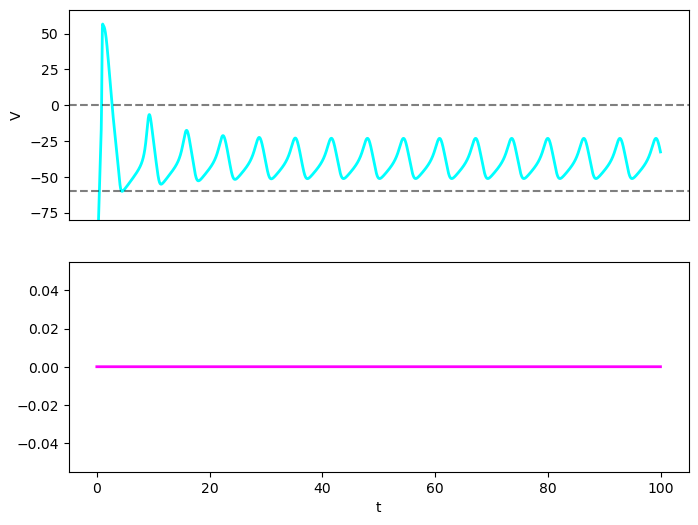

In [51]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create a figure and axis for the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Initialize an empty line object for the plot
line1, = ax1.plot(simulations[0].t, simulations[0].V, lw=2, color="cyan")
line2, = ax2.plot(simulations[0].t, [0 for sim in simulations[0].t], lw=2, color="magenta")

ax1.axhline(0, color="k", linestyle="--", alpha=0.5)
ax1.axhline(hh.reset, color="k", linestyle="--", alpha=0.5)
ax1.set_ylabel("V")
ax1.set_ylim(-80, np.max(hh.V) + 10)
ax1.set_xticks([])
ax1.set_xticklabels([])

ax2.set_xlabel("t")

# Define the update function for the animation
def update(frame):

    # Update the line object with the new data
    hh = simulations[frame]
    line1.set_data(hh.t, hh.V)
    # line2.set_data(hh.t, [0 for sim in simulations[0].t])
    return (line1,line2,)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(simulations), blit=True)

# Display the animation
# ani.save('./hodgkin_huxley_animation.gif', writer='Pillow', fps=10)
HTML(ani.to_jshtml())

# Question 2: The Izhikevich Neuron

## 2a.
We will now implement an Izhikevich (Izhi) neuron model. Below is the class definition of an Izhi neuron. Like before, your task is to fill in the different components required to simulate an Izhi neuron. You should notice one key difference in the implementation: While our HH implementation relied on the odeint libary from scipy for integration, here we will use 'Euler's method' to integrate. The Euler's method is very intuitive, simple, and can be easily implemented. For your reference, the dynamics of an Izhi neuron are described in equations 1, 2, 3 in the paper: https://www.izhikevich.org/publications/spikes.pdf

In [52]:
class Izhi():
    """Implementation of the Izhikevich neuron Model"""
    def __init__(self, a, b, c, d, Vth, T, dt):
        """
        :param a, b, c, d: Izhi neuron parameters
        :param Vth: Voltage threshold for spiking
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.Vth = Vth
        self.u = self.b * self.c #initialize u
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt)
        self.I = 10 #Input stimulus current
        
    def run(self):
        """
        Main function to simulate Izhi neuron and plot voltage and current against time. 
        Fill in the update equations for du, dv, v[t] and u[t] and resetting on spiking.
        """
        V = np.zeros(len(self.t)) #Initialize a numpy array containing the membrane voltages for all the timesteps
        V[0] = self.c #Initial membrane voltage is the rest potential, defined by the parameter 'c'
        u = np.zeros(len(self.t)) #Initialize a numpy array containing u for all the timesteps
        u[0] = self.u #Initial u
        
        for t in range(1, len(self.t)): #the time loop for performing euler's integration
            c_v = V[t-1]
            dv = 0.04*(c_v)**2 + 5 * c_v + 140 - u[t-1] + self.I #compute increment in voltage
            du = self.a * (self.b * c_v - u[t-1]) #compute increment in u
            V[t] = c_v + dv * self.dt #update the voltage
            u[t] = u[t-1] + du * self.dt #update u
            
            #condition for when membrane potential is greater than the threshold
            if V[t] >= self.Vth:
                V[t] = self.c #reset v
                u[t] = u[t] + self.d #reset u
                
        #plotting
        """This function is complete. You do not need to do anything here"""
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Izhi Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        
        plt.show()

## 2b. 
Initialize an Izhi neuron with the correct parameters and run the simulation. You should again be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

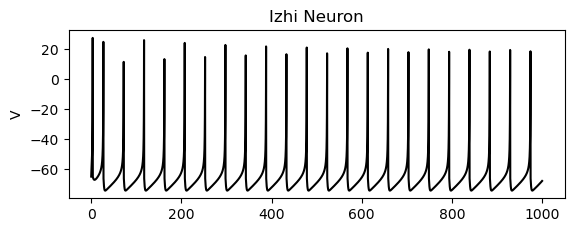

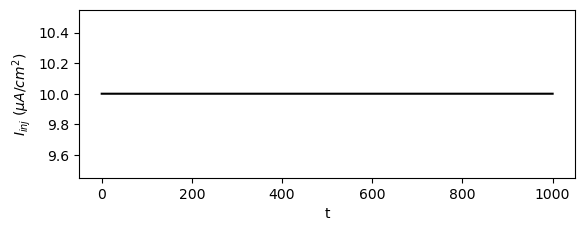

In [53]:
#1. Initialize an izhikevich neuron with the appropriate parameters
izhi = Izhi(a=0.02, b=0.2, c=-65, d=8, Vth=30, T=1000, dt=0.1)

#2. Run the simulation and obtain the results
izhi.run()

## 2c.
Change the parameters of the Izhi neuron in the code to replicate two different patterns identified in neurons, e.g., bursting and adaptation. You can find the parameters for several different Izhi models here: https://www.izhikevich.org/publications/spikes.pdf

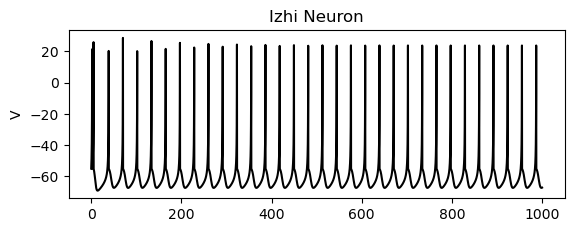

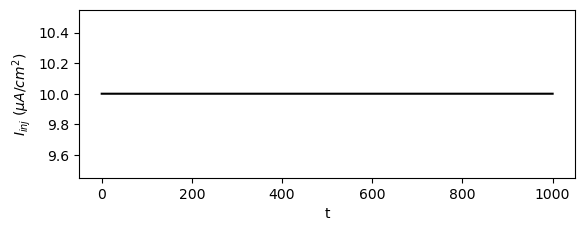

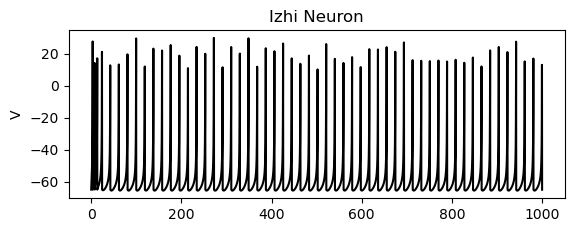

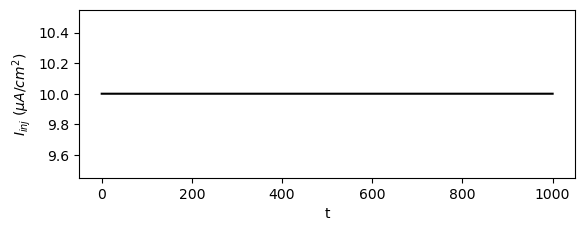

In [54]:
#Write your implementation of the bursting and chattering neuron here

#1. Initialize an izhikevich neuron with the appropriate parameters
#2. Run the simulation and obtain the results
bursting = Izhi(a=0.02, b=0.2, c=-55, d=4, Vth=30, T=1000, dt=0.1)
bursting.run()

adapt = Izhi(a=0.02, b=0.2, c=-65, d=2, Vth=30, T=1000, dt=0.1)
adapt.run()

# Question 3: The LIF Neuron

## 3a. 
In this question, you will implement the almighty leaky integrate and fire neuron (LIF). The LIF neuron is the most widely-used model of a neuron in the SNN literature and you will be using it a lot for your course assignments and for your project. Below is the class definition of an LIF neuron. Just like the Izhi neuron, we will use Euler's method to perform integration. There is one key difference however: For HH and Izhi implementations, the neuron was taking current as the input. In our LIF implementation, the neuron takes spike-trains as inputs and produces spike-trains as output, similarly to how a real neuron works. 

As a hint, we provide here a discrete-time version of an LIF neuron:

* First, integrate the input spikes into current with some decay factor

$$C[t] = C[t-1] * current\_decay + input\_spike[t]$$

* Then, integrate the current  into voltage with some decay factor

$$V[t] = V[t-1] * voltage\_decay + C[t]$$

* Lastly produce a spike if the voltage exceeds the threshold, and reset voltage

$$if V[t] >= Vth  \\ output\_spike[t] = 1 \ and \ V[t] = Rest\_Potential $$

In [55]:
class LIF():
    """Implementation of Leaky integrate and fire neuron Model"""
    def __init__(self, dc, dv, Vth, Vr):
        """
        :param dc: Decay factor for current
        :param dv: Decay factor for voltage
        :param Vth: Voltage Threshold
        :param Vr: Rest potential 
        
        This function is complete. You do not need to do anything here
        """
        self.dc = dc
        self.dv = dv
        self.Vth = Vth
        self.Vr = Vr
    
    def run(self, in_spikes):
        """
        Main function to simulate LIF neuron
        :param in_spikes: Input spike train
        :return out_spikes: output spike train
        
        Fill in the parts for updating Cm, Vm, and the condition for spiking and resetting
        """
        Vm, Cm, out_spikes = [np.zeros(len(in_spikes)) for _ in range(3)] #initialize the state variables
        for t in range(1, len(in_spikes)): #Time loop to perform Euler's Integration
            Cm[t] = Cm[t-1] * self.dc + in_spikes[t] #Integrate input spikes into current
            Vm[t] = Vm[t-1] * self.dv + Cm[t] #Integrate current into voltage
            #condition for when membrane potential is greater than the threshold
            if Vm[t] >= self.Vth:
                out_spikes[t] = 1
                Vm[t] = self.Vr

        
        return out_spikes

## 3b. 
Based on the class definition above, create an LIF neuron with the following parameters: dc = 0.5, dv = 0.5, Vth = 0.50, Vr = 0. 
Then apply to the neuron a random spike train for 15 timesteps. You might find the following numpy package useful to generate the input spike train:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Simulate the neuron and print input and output spikes. 

In [56]:
#1. Create an LIF neuron with the required parameters using the class definition above
lif = LIF(dc=0.5, dv=0.5, Vth=0.5, Vr=0)

#2. Generate a random input spike train of 15 timesteps using the numpy random choice library function
in_spikes = np.random.choice([0, 1], size=(15,), p=[0.5, 0.5])

#3. Print the input spikes
print(in_spikes)

#4. Stimulate the LIF neuron with input spikes and return the output spikes
out_spikes = lif.run(in_spikes)

#5. Print the output spikes
print(out_spikes)

[1 0 0 0 1 1 1 0 1 0 1 0 0 1 0]
[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


# Question 4: Biology vs. Efficiency
Now that you have simulated spiking neuron models at different levels of abstraction, we will learn how to differentiate between the three neuron models that we have developed, based on the following criteria:
* Biological realism
* Computational Efficiency

Can you describe for what tasks might you need an HH model? For what tasks would an LIF neuron be a better alternative?
*Hint*: Why one should use a neuron model that replicates several of the neuron's mechanisms vs. using a model that emulates the neuron as a spike-in-spike-out black box. 

## Answer 4:
The HH model and LIF model are different mostly in their complexity vs ease of use.

**Hodgkin-Huxley (HH) Model:**
One of the main reasons why one might use an abstracted model is because HH is **computationally intensive**. Often times we might need to simulate a large network of HH neurons and using an HH model is both expensive as well as unnecessary since we don't need to replicate the exact behavior of the neuron.

Therefore the HH model is good for tasks where precise replication of neuronal behavior and dynamics is necessary. One good example of this is the study of the neuron's behavior in response to different stimuli like we did with the two drugs in question 1c.

**Leaky Integrate-and-Fire (LIF) Neuron Model:**
The use case of the LIF model is likely the complete opposite. While we won't be able to see exactly how a specific neuron behaves as part of some network, we can simulate a large network of LIF neurons in real-time. This is because the LIF model is **computationally efficient** and is suitable for large-scale simulations and real-time applications.

# Question 5: Tuning Membrane Properties of the LIF neuron
## 5a.
In this question, you will understand how to tune the membrane properties of an LIF neuron. First, generate 19 inputs in the form of random spike trains of length 50, i.e. 50 timesteps. The inputs will have different levels of probabilities for spike generation, that ranges between 0.1 and 1.0 with step size of 0.05. In other words, you will create 19 spike trains with the first spike train having the probability of 0.1 to generate spikes at any timestep, the second spike train will have the spike generation probability of 0.15, and so on. 

Simulate an LIF neuron with the parameters defined in Question 3b. You will now drive the neuron model with the 19 randomly generated input spike trains that you have created, and compute the output spike train. 
At the same time, compute the input firing rate and output firing rate for each simulation. Firing rate is defined as the mean of the spike train, i.e. total number of spikes/timesteps

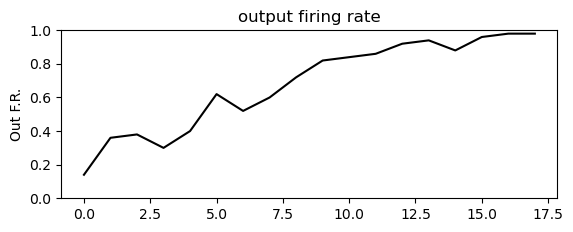

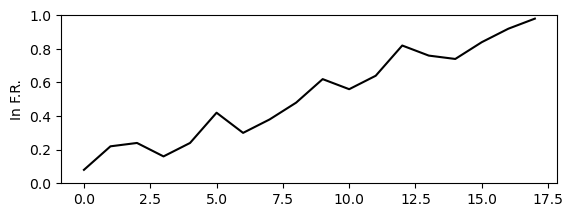

In [57]:
def lif_behavior(lif):
    """Function to understand the behavior of LIF neuron for different densities of spike inputs
    :param lif: An instance of the LIF neuron
    """
    #1. Create lists to store the input and output firing rates
    in_fr = [] #input firing rate
    out_fr = [] #output firing rate
    
    #2. Create a list of probabilities: from 0.1 to 1.0 with step size of 0.05. You might find the numpy arange function helpful here.
    probabilities = np.arange(0.1, 1.0, 0.05)
    
    #3. Loop through the range of probabilities
    for p in probabilities:
        #sample input spikes using np.random.choice function
        in_spikes = np.random.choice([0, 1], size=(50,), p=[1-p, p])
        
        #compute input firing rate and append to the in_fr list
        in_fr.append(np.sum(in_spikes) / len(in_spikes))
        
        #obtain output spikes by applying the input to the LIF neuron
        out_spikes = lif.run(in_spikes)
        
        #compute output firing rate and append to the out_fr list
        out_fr.append(np.sum(out_spikes) / len(out_spikes))
        

    #Plot the input and output firing rates. Nothing to do here. This part is complete
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('output firing rate')
    plt.plot(out_fr, 'k')
    plt.ylabel('Out F.R.')
    plt.ylim([0,1])

    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(in_fr, 'k')
    plt.ylabel('In F.R.')
    plt.ylim([0,1])
    plt.show()

#Run the lif behavior function for the LIF neuron that we created previously
lif_behavior(lif)

## 5b. 
Describe how soon does the output firing rate start to saturate? Can you describe why this could be problematic? *Hint: Think from the point of view of distinguishing between two different inputs based on firing activity*

## Answer 5b.
It looks like the output firing rate starts to saturate when the input spikes fire at 0.75. This is problematic because it means that the neuron is not able encode the additional information coming in. This is a problem because the neuron is not able to distinguish between two different inputs based on firing activity even though one might be significantly greater than the other.

## 5c. 
Change the membrane properties of the LIF neuron to resolve the issue of saturation. In other words, experiment on setting different parameter values that do not allow the output firing rate to saturate so early. *Hint: You may want to start by changing one variable at a time, and see its effect. Try to move it slightly, or abruptly, up or down. Then move to the next parameter, until you see what is its effect on the neuron's output.* 

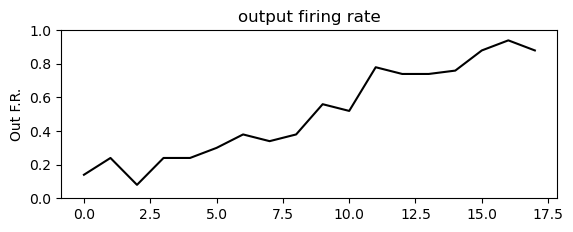

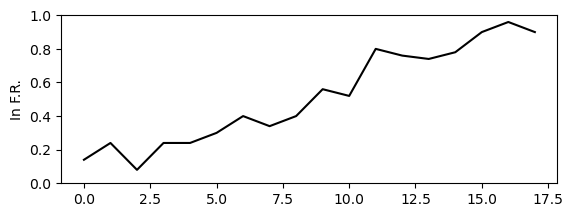

In [58]:
#1. Create an LIF neuron with appropriately tuned membrane properties
lif = LIF(dc=0.3, dv=0.3, Vth=0.5, Vr=0)

#2. Call the lif behavior function on the tuned lif neuron
lif_behavior(lif)

## 5d.
Based on the above results, can you describe how changing the H-H parameters changes the voltage threshold of a spiking neuron as a function of the input spikes?

## Answer 5d.
By decreasing the decay factor of the voltage and current, we increase the time it takes for the neuron to get back to its resting potential. This means that the neuron is able to encode more information before it saturates. Alternatively we could have just increased the threshold at which the neuron fires.

# Question 6: Encoding continuous inputs into spikes
## 6a.
Now we will understand how we can represent continuous-valued inputs as spikes so that drive our spiking neuron. Describe two prominent ways to encode a continuous-valued input into the spiking activity of a neuron. 

## Answer 6a.
We can use a threshold encoding scheme where we set a threshold and if the input is greater than the threshold, the neuron fires. Alternatively, we can generate a bunch of random numbers and take some kind of average of them.

## 6b. 
So far we have learned how we can stimulate a spiking neuron using spike inputs. In this exercise, you will learn how to encode real-world data into spikes that can then be fed as inputs to the spiking neuron. We will take a digit from the popular MNIST dataset as an example. First let's see what a sample digit from the MNIST image looks like. For this, we need to create a loader for the MNIST dataset using a Pytorch function called datasets.MNIST. You do not need to know what a loader is for now. Just understand the two important arguments of the function: The first argument is the directory where the MNIST dataset will be downloaded. The third argument is the set download option. This should be true for the first time when you run this cell to allow you to download the MNIST data into your directory. You can set it to false if the MNIST data has already been downloaded. 

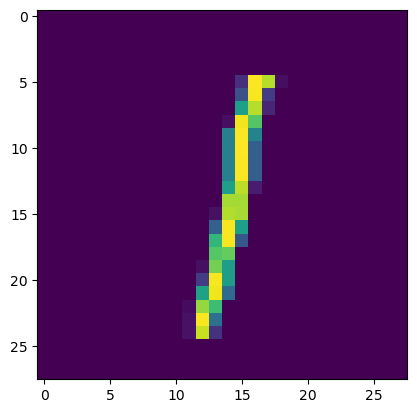

In [59]:
#Create a loader
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

#You can access any sample digit from the MNIST dataset using simple indexing mnist[idx]. This returns the digit and the label. We are only interested in the digit. 
x, _ = random.choice(mnist)
# x, _ = mnist[24] # uncomment this line if you want to fix the target image

#Convert to numpy
x = x.numpy()[0]

#Visualize
plt.imshow(x)

Let's now encode the image in the form of spikes using rate-encoding. Suppose that each pixel in the image needs to be encoded in a spike train of length 1. The steps to encode are outlined below:
* For each pixel in the image, sample a random number.
* If the pixel intensity is greater than the generated random number, output a spike. 
* Repeat for as many timesteps as you need to encode the image for. 
* Repeat for all pixels

In [60]:
#0. Decide the number of spike train here. let us say n_spike = 1 here.
n_spike = 1

spike_encoded_image = np.zeros((x.shape[0], x.shape[1], n_spike))

#1. Use the numpy.random.rand function to encode the MNIST image into spikes
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        spike_encoded_image[i, j, :] = np.random.rand(n_spike) < x[i, j]

#2. Output the shape of the spike-encoded image using numpy.shape (hint: the spike-encoded image should be a 3d arraay)
print(np.shape(spike_encoded_image))

(28, 28, 1)


## 6c. 
Now, we will decode the image back from the spike-based representation. Can you think of a way to get the pixel values back? *Hint: Think aggregate measures on the spike trains for each pixel. Aggregation means compressing of the channel from n to 1.*

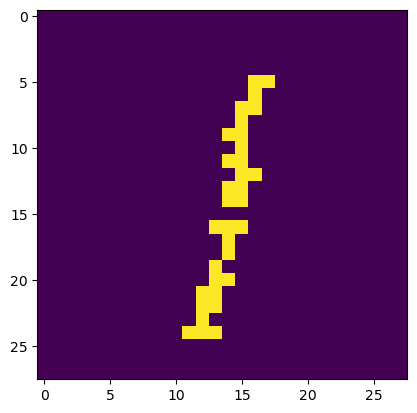

In [61]:
#1. Compute some aggregate measure of spike trains for each pixel to get the image back. Numpy aggregate functions might be useful here
reconstructed_image = np.sum(spike_encoded_image, axis=2)
#2. visualize the reconstructed image
plt.imshow(reconstructed_image)

Is it possible to get the exact image back? Why/Why not?

## Answer 6c.
It is not possible to get the exact image back because we are using a random number generator to encode the image. Because this method of encoding is not deterministic we cannot get the exact image back.

## 6d. 
Can you think of a way to encode the image into spikes in a way such that the decoded image looks as close as possible to the original image? *Hint: Think timesteps*

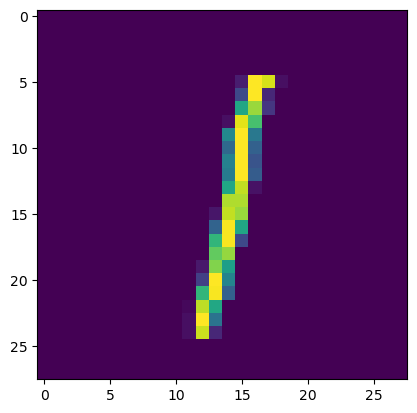

In [62]:
#1. Create a "better" encoding of the image
n_spike = 100
#2. Compute and visualize the decoded image
mean_spike_encoded_image = np.zeros((x.shape[0], x.shape[1], n_spike))

#1. Use the numpy.random.rand function to encode the MNIST image into spikes
for i in range(n_spike):
    random_matr = np.random.rand(x.shape[0], x.shape[1])
    mean_spike_encoded_image[:, :, i] = random_matr < x

decoded_image = np.mean(mean_spike_encoded_image, axis=2)
plt.imshow(decoded_image)

If each intensity pixel is represented with a value between [0, 255], what would be a reasonable timestep to encode it accurately? What might be a disadvantage of this solution?

## Answer 6d. 
For a set of spikes to reach an intensity of 255, we would need to allocate enough time to encode it completely. Therefore the maximum rate would be 255 Hz which is around 4 ms, the disadvantage here is that 4 ms is an awefully long time to encode a single pixel.

## 6e

Can you try at least **two** other aggregation functions to decode the images and describe the differences among them.

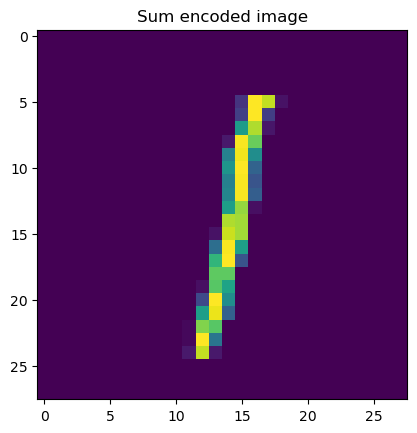

In [63]:
#1 same struction as 6c
sum_spike_encoded_image = np.zeros((x.shape[0], x.shape[1], n_spike))

#1. Use the numpy.random.rand function to encode the MNIST image into spikes
for i in range(n_spike):
    random_matr = np.random.rand(x.shape[0], x.shape[1])
    sum_spike_encoded_image[:, :, i] = random_matr < x

decoded_image = np.sum(sum_spike_encoded_image, axis=2)
plt.title('Sum encoded image')
plt.imshow(decoded_image)

#2 plot the results

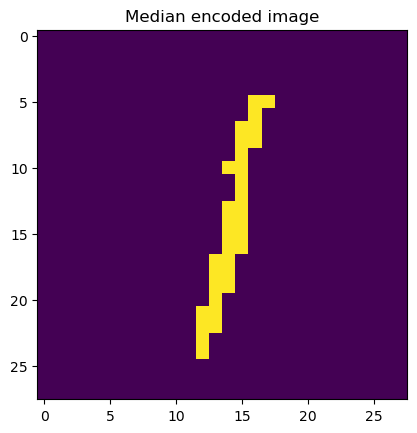

In [64]:
med_spike_encoded_image = np.zeros((x.shape[0], x.shape[1], n_spike))

#1. Use the numpy.random.rand function to encode the MNIST image into spikes
for i in range(n_spike):
    random_matr = np.random.rand(x.shape[0], x.shape[1])
    med_spike_encoded_image[:, :, i] = random_matr < x

decoded_image = np.median(sum_spike_encoded_image, axis=2)
plt.title('Median encoded image')
plt.imshow(decoded_image)

## Answer 6e. 
We can use the sum and median of the spike train to decode the image. The difference is palpable. Where the median simply gives a binary spike or no spike value, the sum gives an image resembling the mean where it is more precise.